# Section 6

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 16,
    'text.latex.preamble': r"\usepackage{amsmath}"
})

In [2]:
import irbasis3

## Generate IR basis by singular value expansion

In [3]:
# Create kenerl for lambda_ = 100 and beta = 10
# The default value of eps ``cutoff for singular values" is
# set to 2.2e-16.
# In this sample, we compute fewer basis functions.
lambda_ = 100
beta = 10
wmax = lambda_/beta
K = irbasis3.KernelFFlat(lambda_=100)
basis = irbasis3.FiniteTempBasis(
    K, statistics='F', beta=beta, eps=1e-10)

## Singular values

In [4]:
basis.s

array([1.45387261e+00, 1.24137141e+00, 7.98387159e-01, 5.34115485e-01,
       3.19202855e-01, 1.88195405e-01, 1.06269952e-01, 5.84664007e-02,
       3.12626140e-02, 1.62959998e-02, 8.28608690e-03, 4.11383766e-03,
       1.99543191e-03, 9.46115126e-04, 4.38678206e-04, 1.98971153e-04,
       8.83076718e-05, 3.83596425e-05, 1.63120097e-05, 6.79164595e-06,
       2.76915058e-06, 1.10582146e-06, 4.32562293e-07, 1.65764896e-07,
       6.22400190e-08, 2.28998146e-08, 8.25716208e-09, 2.91821977e-09,
       1.01098806e-09, 3.43374895e-10])

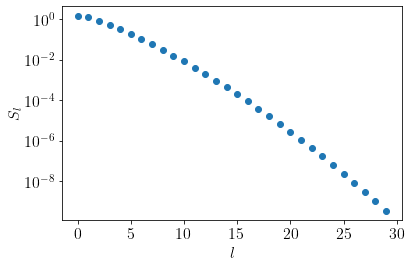

In [5]:
plt.semilogy(basis.s, marker='o', ls='')
plt.xlabel(r'$l$')
plt.ylabel(r'$S_l$')
plt.tight_layout()
plt.savefig('ir_basis_svals.pdf', transparent=True)

## $U_l(\tau)$ and $V_l(\omega)$

In [6]:
basis.u(np.array([0, 0.5*beta, beta]))

array([[ 1.12756986e+00,  1.59488091e-01,  1.12756986e+00],
       [-1.55855086e+00,  9.21156776e-19,  1.55855086e+00],
       [ 1.72691406e+00, -2.44209277e-01,  1.72691406e+00],
       [-1.88082340e+00, -1.84231355e-18,  1.88082340e+00],
       [ 1.88921360e+00,  2.67002917e-01,  1.88921360e+00],
       [-1.93558827e+00,  3.68462710e-18,  1.93558827e+00],
       [ 1.96432680e+00, -2.77301091e-01,  1.96432680e+00],
       [-2.00124241e+00,  0.00000000e+00,  2.00124241e+00],
       [ 2.03647135e+00,  2.86961406e-01,  2.03647135e+00],
       [-2.07219497e+00, -7.36925421e-18,  2.07219497e+00],
       [ 2.10714740e+00, -2.96143856e-01,  2.10714740e+00],
       [-2.14147567e+00,  0.00000000e+00,  2.14147567e+00],
       [ 2.17510637e+00,  3.04622473e-01,  2.17510637e+00],
       [-2.20810966e+00,  0.00000000e+00,  2.20810966e+00],
       [ 2.24054777e+00, -3.12379703e-01,  2.24054777e+00],
       [-2.27249083e+00, -1.47385084e-17,  2.27249083e+00],
       [ 2.30400318e+00,  3.19450356e-01

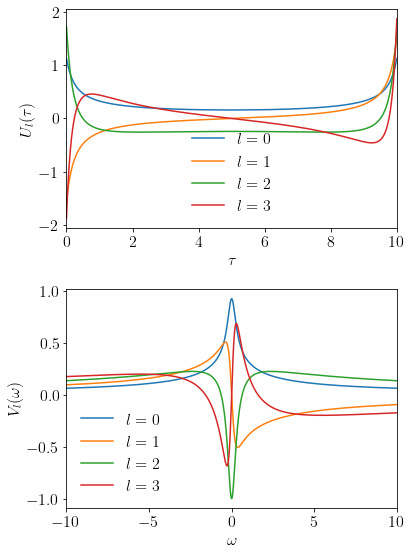

In [7]:
fig = plt.figure(figsize=(6,8))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
axes = [ax1, ax2]

taus = np.linspace(0, beta, 1000)
omegas = np.linspace(-wmax, wmax, 1000)

for l in range(4):
    ax1.plot(taus, basis.u[l](taus), label=f'$l={l}$')
    ax2.plot(omegas, basis.v[l](omegas), label=f'$l={l}$')

ax1.set_xlabel(r'$\tau$')
ax2.set_xlabel(r'$\omega$')
ax1.set_ylabel(r'$U_l(\tau)$')
ax2.set_ylabel(r'$V_l(\omega)$')
ax1.set_xlim([0,beta])
ax2.set_xlim([-wmax, wmax])

ax1.legend(loc='best', frameon=False)
ax2.legend(loc='best', frameon=False)
plt.tight_layout()
plt.savefig('ir_basis_functions.pdf', transparent=True)

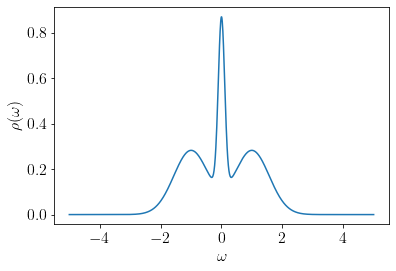

In [8]:
# Three Gaussian peaks (normalized to 1)
gaussian = lambda x, mu, sigma: np.exp(-((x-mu)/sigma)**2)/(np.sqrt(np.pi)*sigma)

rho = lambda omega: 0.2*gaussian(omega, 0.0, 0.15) + \
    0.4*gaussian(omega, 1.0, 0.8) + 0.4*gaussian(omega, -1.0, 0.8)

omegas = np.linspace(-5, 5, 1000)
plt.xlabel(r'$\omega$')
plt.ylabel(r'$\rho(\omega)$')
plt.plot(omegas, rho(omegas))

In [9]:
# Piecewise Quadrature rule over [-wmax, wmax]
# The inverval [-wmax, wmax] is divided by the roots of the IR basis function V_l(omega) for the larget l
# Gauss-Legendre quadrature rule of degree 20 is applied to each subinterval.
edges = np.hstack((-wmax, basis.v[-1].roots(), wmax))
rule = irbasis3._gauss.legendre(20).piecewise(edges)

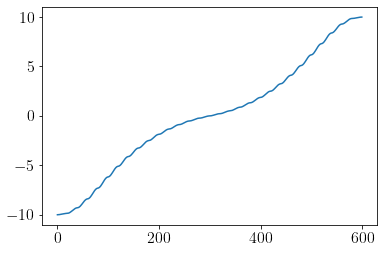

In [10]:
# Plot the position of nodes
plt.plot(rule.x)

In [11]:
# Check orthogonality condition
for i in range(basis.size):
    for j in range(i, basis.size):
        overlap = sum(rule.w * 
            basis.v[j](rule.x) *
            basis.v[i](rule.x)
        )
        print(overlap)

0.9999999999999991
4.431676380034499e-18
-2.543470534015213e-16
-5.3442696774062826e-17
5.659874153553235e-17
-4.977165598066269e-18
5.2085749992561436e-17
3.113693114106808e-18
8.296179498587519e-17
3.411848711540322e-17
3.630722025110833e-17
9.378348791999613e-18
-1.1092743477242317e-17
-1.3410225620930083e-17
5.711712569925198e-17
-3.6266562669640123e-17
-5.246860888472038e-17
-8.382238046028556e-18
-3.6578270794229706e-17
-1.2224379494774062e-17
5.105236979691119e-17
-1.6351124013797014e-17
-1.791644090032296e-16
-3.747273758653025e-18
-2.485533480423019e-17
-1.5856456772600502e-17
-5.70019292184254e-17
3.144186300207963e-18
-6.369687763352339e-17
-8.131516293641283e-20
1.0
1.4643505592132344e-16
1.3554560035142216e-16
-1.3349239248727773e-17
-1.3967573300223413e-16
-1.0638733817514012e-17
-3.920068479892902e-17
-4.403216073006755e-17
6.130485659047724e-17
7.948557177034354e-18
-4.269046054161674e-18
-1.0984323259993767e-17
7.338693455011258e-17
-1.7618285302889447e-18
2.1833121248